In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import xarray as xr
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import cartopy as cart

from glob import glob
from datetime import timedelta as delta
from datetime import datetime

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import plot
import lifeline

In [39]:
reload(plot)
reload(lifeline)

<module 'lifeline' from '/home/students/4302001/arctic-connectivity/EEZ/lifeline.py'>

In [11]:
# Specify paths to velocity field and mesh
#readdir_ocean = '/Users/daanreijnders/Datasets/'
#readdir_ice = '/Users/daanreijnders/Datasets/'

readdir_ice = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_ocean = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ocean/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean = 'daily_CESM_0.1degree_controlrun_year_300_arctic_region_timed.nc'
fieldfile_ice = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic'
meshfile = 'POP_grid_lat1800plus.nc'

writedir = ''

In [12]:
def read_velocity_field(fieldfiles, meshfiles=None):
    if not meshfiles:
        meshfiles = fieldfiles
    filenames = {'U': {'lon': meshfiles,
                       'lat': meshfiles,
                       'data':fieldfiles},
                 'V': {'lon': meshfiles,
                       'lat': meshfiles,
                       'data':fieldfiles}}

    variables = {'U': 'UVEL_5m',
                 'V': 'VVEL_5m'}

    dimensions = {'U': {'time': 'time',
                        'lat': 'U_LAT_2D',
                        'lon': 'U_LON_2D'},
                  'V': {'time': 'time',
                        'lat': 'U_LAT_2D',
                        'lon': 'U_LON_2D'}}
    fieldset = FieldSet.from_pop(filenames, variables, dimensions, allow_time_extrapolation=False)
    fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
    fieldset.V.vmax = 10; fieldset.V.vmin = -10;
    return fieldset

fieldset = read_velocity_field(readdir_ocean+fieldfile_ocean, readdir_mesh+meshfile)  

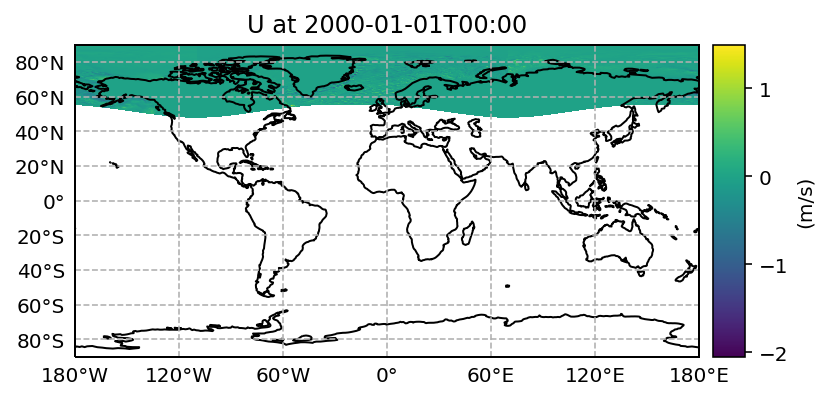

In [13]:
plot.show(fieldset.U, land=False)

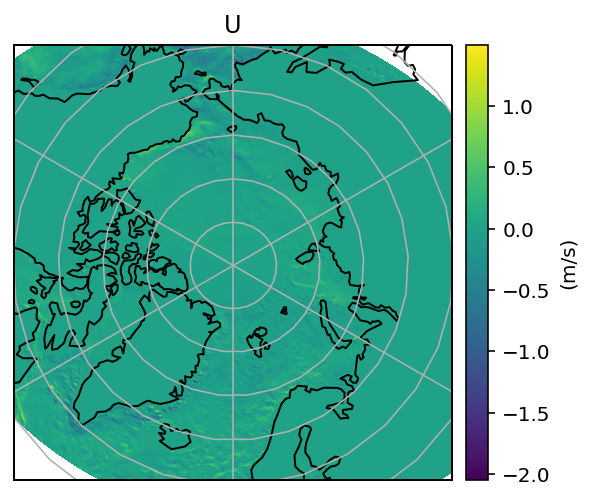

In [9]:
plot.show(fieldset.U, latRange=(60,90), land=False, polar=True)

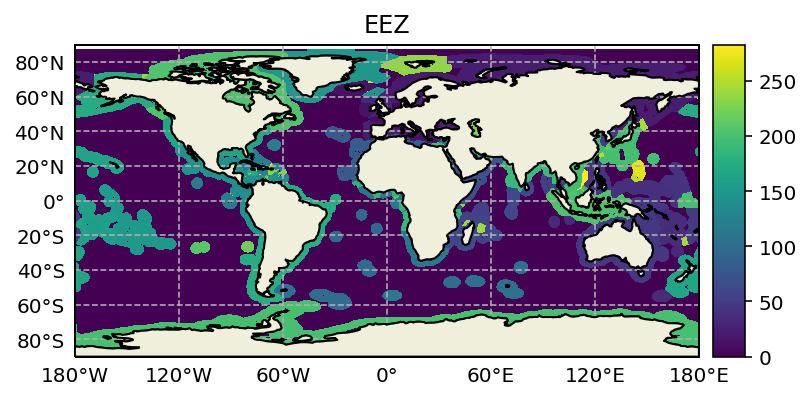

In [10]:
# Load and add EEZ field
EEZ_ds = xr.open_dataset('EEZ.nc')
EEZ = EEZ_ds['EEZ'][:,:]
EEZ_lats = EEZ_ds['latitude'].data
EEZ_lons = EEZ_ds['longitude'].data

EEZ_field = Field(name="EEZ", data=EEZ.data[0], mesh='spherical', lon=EEZ_lons, lat=EEZ_lats, allow_time_extrapolation=True)
fieldset.add_field(EEZ_field)

plot.show(fieldset.EEZ)

In [11]:
# Kernels and particle classes
class myParticle(JITParticle):
    EEZ = Variable('EEZ', dtype=np.int32, to_write=True)

def EEZ_sampler(particle, fieldset, time):
    particle.EEZ = fieldset.EEZ[time, 0., particle.lat, particle.lon]
        
def wrapLon(particle, fieldset, time):
    if particle.lon > 180.:
        particle.lon = particle.lon - 360.
    if particle.lon < -180.:
        particle.lon = particle.lon + 360.

def deleteParticle(particle, fieldset, time):
    particle.delete()

In [12]:
def printState(particle, fieldset, time):
    print("particle latitude:", particle.lat)
    print("particle longitude:", particle.lat)

In [13]:
# Particle execution function
def execute_particles(fieldset, \
                      experiment_name='', \
                      npart=10, \
                      runtime=delta(days=200), \
                      dt = delta(minutes=5), \
                      outputdt = delta(hours = 6), \
                      start=(3,75), \
                      show_pset=False):
    startLons = np.ones(npart) * start[0]
    startLats = np.ones(npart) * start[1]
    startTime = np.array([datetime(2000, 1, 1) + delta(days = i) for i in range(npart)]) 
    pset = ParticleSet.from_list(fieldset=fieldset, pclass=myParticle, lon=startLons.tolist(), lat=startLats.tolist(), \
                       time = startTime)
    if show_pset:
        edge = 5 # Degrees around initial distribution
        pset.show()

    kernels = pset.Kernel(AdvectionRK4) + EEZ_sampler + wrapLon + printState
    pfile = pset.ParticleFile(name = writedir+experiment_name+"_particles", outputdt=outputdt)
    print(f"Run: Advecting {npart} particles for {runtime}")

    pset.execute(kernels, \
                 runtime = runtime, \
                 dt = dt, \
                 output_file = pfile, \
                 recovery = {ErrorCode.ErrorOutOfBounds: deleteParticle})
    return pset

In [ ]:
pset_loc1 = execute_particles(fieldset, experiment_name='pset_EEZ_loc1', start=(-50,58), show_pset=True, npart = 1000, runtime=delta(days=200) )

In [ ]:
pset_loc2 = execute_particles(fieldset, experiment_name='pset_EEZ_loc2', start=(5.15,58.85), show_pset=True, npart = 1000)

In [ ]:
%%time
# Investigate data. Which EEZs are visited?
pfile_loc1 = xr.open_dataset('pset_EEZ_loc1_particles.nc', decode_cf=True)
pfile_loc2 = xr.open_dataset('pset_EEZ_loc2_particles.nc', decode_cf=True)

plot.particleAnimation.create(pfile_loc1, fieldset.EEZ, nbar=6, exportFolder='figures', titleAttribute='MidNorth')
plot.particleAnimation.create(pfile_loc1, fieldset.U, exportFolder='figures', titleAttribute='NorwayBay')

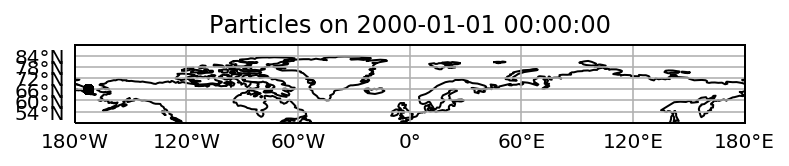

Run: Advecting 1000 particles for 10 days, 0:00:00


INFO: Compiled myParticleAdvectionRK4EEZ_samplerwrapLonprintState ==> /tmp/parcels-23300/86b3bb735e6f012223db1275990f9715.so


In [16]:
pset_loct1a = execute_particles(fieldset, experiment_name='pset_EEZ_loct_1a', start=(-173,66), show_pset=True, npart = 1000, runtime=delta(days=10) )

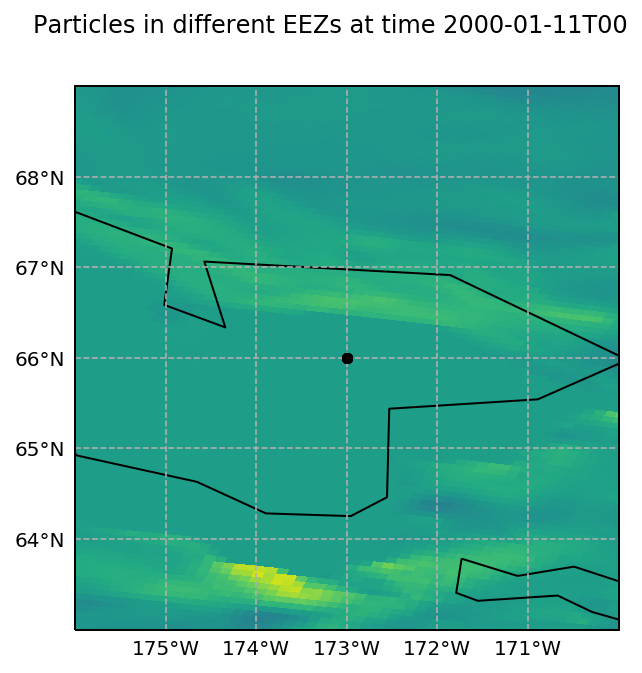

In [17]:
pfile_loct_1a = xr.open_dataset('pset_EEZ_loct_1a_particles.nc', decode_cf=True)
plot.particleAnimation.create(pfile_loct_1a, fieldset.U, mask=False, exportFolder='figures', titleAttribute='Test_1a')
pfile_loct_1a.close()

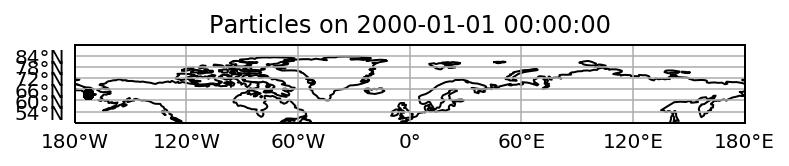

Run: Advecting 1000 particles for 10 days, 0:00:00


INFO: Compiled myParticleAdvectionRK4EEZ_samplerwrapLonprintState ==> /tmp/parcels-23300/92369da107af65d2e0110761da260f80.so


In [18]:
pset_loct1b = execute_particles(fieldset, experiment_name='pset_EEZ_loct_1b', start=(-173,63.5), show_pset=True, npart = 1000, runtime=delta(days=10) )

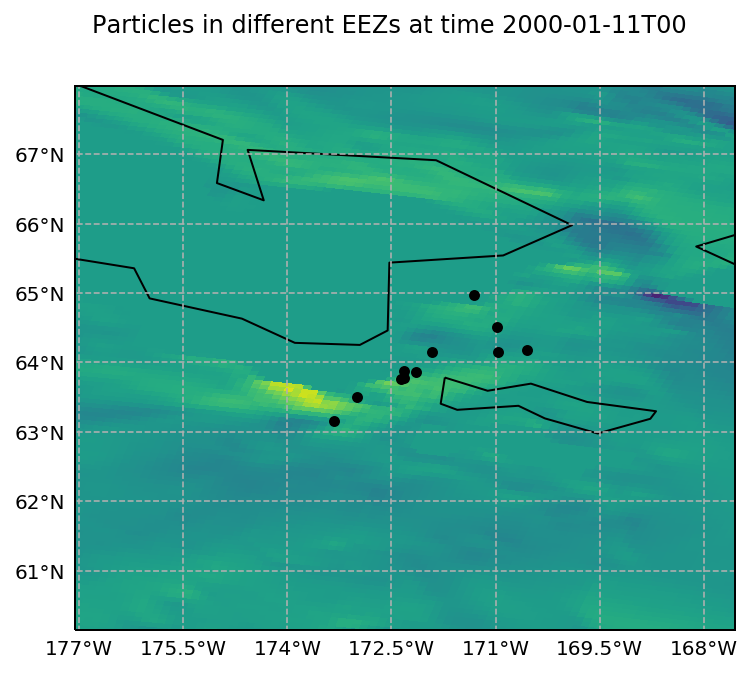

In [19]:
pfile_loct_1b = xr.open_dataset('pset_EEZ_loct_1b_particles.nc', decode_cf=True)
plot.particleAnimation.create(pfile_loct_1b, fieldset.U, mask=False, exportFolder='figures', titleAttribute='Test_1b')
pfile_loct_1b.close()

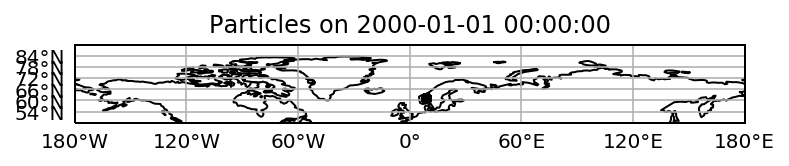

Run: Advecting 1000 particles for 10 days, 0:00:00


INFO: Compiled myParticleAdvectionRK4EEZ_samplerwrapLonprintState ==> /tmp/parcels-23300/ed66f0eff8e5058175f85ae47184bbd1.so


In [20]:
pset_loct2 = execute_particles(fieldset, experiment_name='pset_EEZ_loct_2', start=(9, 61.5), show_pset=True, npart = 1000, runtime=delta(days=10) )

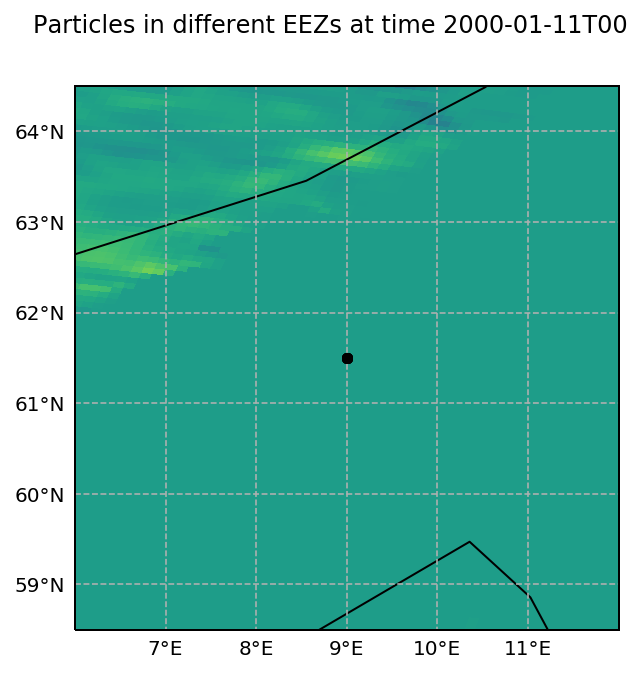

CPU times: user 1min 26s, sys: 12.3 s, total: 1min 38s
Wall time: 1min 31s


In [21]:
%%time
pfile_loct_2 = xr.open_dataset('pset_EEZ_loct_2_particles.nc', decode_cf=True)
plot.particleAnimation.create(pfile_loct_2, fieldset.U, mask=False, exportFolder='figures', titleAttribute='Test_2')
pfile_loct_2.close()

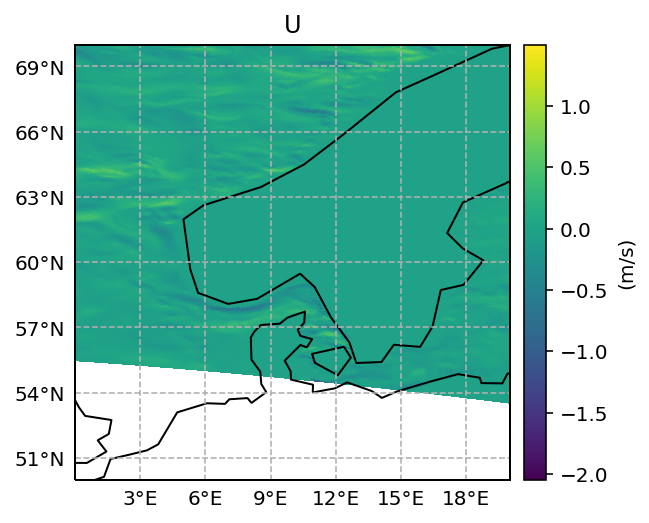

In [15]:
plot.show(fieldset.U, latRange=(50,70), lonRange=(0,20), land=False, export='NorwayNoBleed')

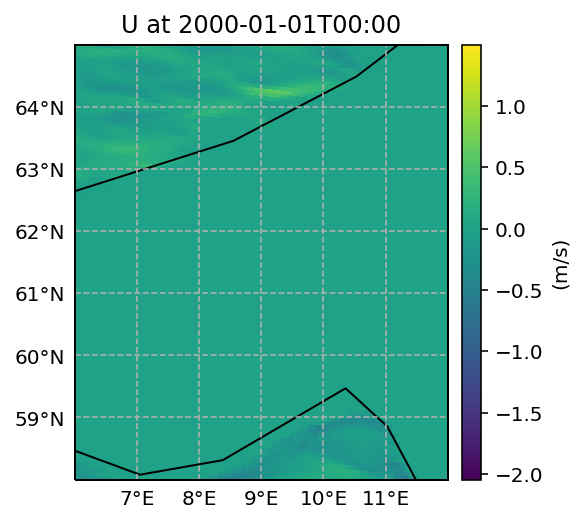

In [40]:
plot.show(fieldset.U, latRange=(58,65), lonRange=(6,12), land=False, export='NorwayNoBleedZoom')